# Computes PLV features for later classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io as sio
import os
import ieeg_funcs as ief
import dgFuncs as dg
import pickle

In [ ]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

In [2]:
path_dict=ief.get_path_dict()
# path_dict.keys()
use_subs_df=pd.read_csv(os.path.join(path_dict['szr_ant_root'],'use_subs.txt'),header=None,na_filter=False)

In [3]:
print(use_subs_df)

    0
0  CC
1  CJ
2  CO
3  CT
4  IB
5  JW
6  NA
7  RB
8  TF


In [ ]:
for sub in use_subs_df.iloc[:,0]:
    print(sub)

In [4]:
# Features:
# central window
# 1 second window, ends 1 sec previous
# mean of 10 second window, ends 1 sec previous

wind_len=1

# 1 second window, ends 1 sec previous
# prev_wind_width=(1, 1, 10) # two 1 second windows and a 10 second window) 
# prev_wind_delay=(0, 1, 1) # centered window, and two 1 sec before center windows 

# 10 second window, ends 1 sec previous

# Time to use:
# -all preictal data
# -10 seconds past onset window

In [3]:
# Load list of subs to use
#use_subs.txt TODO use this text file
sub_list=['NA']
# sub_list=['CO']
# TODO loop over subs
sub=sub_list[0]

In [4]:
path_dict = ief.get_path_dict()
ieeg_root = path_dict['ieeg_root']

# Get list of files to use from clinician onset csv file
onset_csv_dir=path_dict['onset_csv']
onset_csv_fname=os.path.join(onset_csv_dir,sub+'_clinician_onset_offset.csv')
print('Importing file %s' % onset_csv_fname)
onset_df=pd.read_csv(onset_csv_fname)

Importing file /Users/davidgroppe/Dropbox/TWH_INFO/CLINICIAN_ONSET_TIMES/NA_clinician_onset_offset.csv


In [7]:
onset_df.head()

,DAY,SZR#,ONSET,OFFSET,SOZ_CHAN,FILE_ONSET,DDMMYR,SRATE_HZ,NOTES,ONSET_SEC,FILE_ONSET_SEC,ONSET_TPT,DG_ONSET_CHAN,USE4CLASSIFIER
0,1,1,8:59:03 PM,9:38:35 PM,?,?,06/23/2009,500,?,75543,NaN,NaN,?,noEEGdata
1,1,2,1:54:41 AM,1:55:52 AM,RHD1,1:52:45,06/23/2009,500,?,6881,6765.0,58000.0,RHD1-2,use
2,1,3,2:42:25 AM,2:43:58 AM,?,2:39:36,06/23/2009,500,?,9745,9576.0,84500.0,RHD1-2,use
3,1,4,4:51:59 AM,4:53:35 AM,?,4:49:03,06/23/2009,500,?,17519,17343.0,88000.0,RHD1-2,use
4,1,5,6:29:14 AM,6:31:11 AM,?,6:26:20,06/23/2009,500,?,23354,23180.0,87000.0,RHD1-2,use


In [5]:
use_ser=onset_df['USE4CLASSIFIER']
use_szrs=list()
# onset_chans=list()
for row_id, quality in enumerate(use_ser):
    if quality=='use':
        szr_name=sub+'_d'+str(onset_df.iloc[row_id,0])+'_sz'+str(onset_df.iloc[row_id,1])
        use_szrs.append(szr_name)
#         onset_chans.append(onset_df.iloc[row_id,12])
n_use_szrs=len(use_szrs)
print('%d usable szrs:' % n_use_szrs)
print(use_szrs)
# print(onset_chans)

5 usable szrs:
['NA_d1_sz2', 'NA_d1_sz3', 'NA_d1_sz4', 'NA_d1_sz5', 'NA_d2_sz1']


In [ ]:
# Block for re-loading my libraries if I make updates
import imp 
imp.reload(ief) 
imp.reload(dg) 

In [ ]:
ieeg.shape

In [ ]:
#bro=ieeg[onset_chan_id:onset_chan_id+1,:]
bro=ieeg[22:23,:]
bro.shape

In [7]:
# Import data from one szr to estimate PLV

# Import channel names
chan_labels=ief.import_chan_labels(sub)

# Loop over usable files
for szr_ct, szr_name in enumerate(use_szrs[0:1]): # ?? REVERT
#for szr_ct, szr_name in enumerate(use_szrs):
    # Load data
    in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'.mat')
    if not os.path.isfile(in_fname):
        # Must be a subclinical seizure
        in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'_sc.mat')
    szr_name_full=in_fname.split('/')[-1]
    ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name_full)

Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv
Loading /Users/davidgroppe/ONGOING/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat


In [33]:
np.linspace(0,1,3)

array([ 0. ,  0.5,  1. ])

In [68]:
onset_chan_id=12
contra_chan_id=0
print(chan_labels[contra_chan_id])
print(chan_labels[onset_chan_id])

wind_len=Sf
wind_step=Sf/10
data1=ieeg[onset_chan_id,:]
data2=ieeg[contra_chan_id,:]
# data1=np.cos(np.linspace(0,2*np.pi*10000,n_tpt))
# data2=np.sin(np.linspace(0,2*np.pi*10000,n_tpt))

n_tpt = len(data1)
wind_cntr = np.arange(wind_len, n_tpt, wind_step)
wind_len = int(np.round(wind_len))
wind_step = int(np.round(wind_step))
# Compute # of time windows
n_wind = len(wind_cntr)

# Hamming taper
tpr = np.hamming(wind_len)

# Compute frequencies
nyq=Sf/2
T=wind_len/Sf # length of moving window in seconds
freq_spacing = 1 / T
f = np.linspace(0, nyq, 1 + nyq / freq_spacing)
n_freq = len(f)
dft_sec=np.zeros(n_wind)

# preallocate mem
# phz1=np.zeros((n_freq,n_wind))
# phz2=np.zeros((n_freq,n_wind))
delta_phz=np.zeros((n_freq,n_wind))

# Loop over iEEG windows, do DFT, and calculate phase difference
cursor = 0
for wind in range(n_wind):
    dft_sec[wind]= np.mean(tpts_sec[cursor:cursor + wind_len])
    
    # norm='ortho' means that no scaling factor is necessary to do inverse fft
    spec1=np.fft.rfft(np.multiply(data1[cursor:cursor + wind_len],tpr), wind_len, norm='ortho')
    phase1=np.angle(spec1)
    
    spec2=np.fft.rfft(np.multiply(data2[cursor:cursor + wind_len],tpr), wind_len, norm='ortho')
    phase2=np.angle(spec2)
    
    delta_phz[:,wind]=phase1-phase2
#     sgram[:, wind] = 10 * np.log10(np.abs(spec))
#     sgram_sec[wind] = np.mean(time_sec[cursor:cursor + wind_len])
    cursor += wind_step

# Loop over phase windows and calculate PLV
p_Sf=1/(dft_sec[1]-dft_sec[0]) # DFT moving window sampling rate
p_wind_len=int(np.round(p_Sf)) # one second window
p_wind_step=1
p_wind_cntr = np.arange(p_wind_len, n_wind, p_wind_step)
# Compute # of time windows
p_n_wind = len(p_wind_cntr)
print(p_n_wind)

# Preallocate mem
pgram=np.zeros((n_freq,p_n_wind))
p_sec=np.zeros(p_n_wind)

cursor = 0
for wind in range(p_n_wind):
    pgram[:,wind]=np.abs(np.mean(np.exp(1j*delta_phz[:,cursor:cursor+p_wind_len]),axis=1))
    p_sec[wind]=np.mean(dft_sec[cursor:cursor+p_wind_len])
    cursor+=p_wind_step
    
# Average over frequency bands


LHD1-2
RHD1-2
1850


In [95]:
def plvgram(data1,data2,Sf,wind_len,wind_step,tpts_sec):
    wind_len = int(np.round(wind_len))
    wind_step = int(np.round(wind_step))
    n_tpt = len(data1)
    wind_cntr = np.arange(wind_len, n_tpt, wind_step)

    # Compute # of time windows
    n_wind = len(wind_cntr)

    # Hamming taper
    tpr = np.hamming(wind_len)

    # Compute frequencies
    nyq=Sf/2
    T=wind_len/Sf # length of moving window in seconds
    freq_spacing = 1 / T
    f = np.linspace(0, nyq, 1 + nyq / freq_spacing)
    n_freq = len(f)

    # preallocate mem
    delta_phz=np.zeros((n_freq,n_wind))
    dft_sec=np.zeros(n_wind)

    # Loop over iEEG windows, do DFT, and calculate phase difference
    cursor = 0
    for wind in range(n_wind):
        dft_sec[wind]= np.mean(tpts_sec[cursor:cursor + wind_len])
    
        # norm='ortho' means that no scaling factor is necessary to do inverse fft
        spec1=np.fft.rfft(np.multiply(data1[cursor:cursor + wind_len],tpr), wind_len, norm='ortho')
        phase1=np.angle(spec1)
    
        spec2=np.fft.rfft(np.multiply(data2[cursor:cursor + wind_len],tpr), wind_len, norm='ortho')
        phase2=np.angle(spec2)
    
        delta_phz[:,wind]=phase1-phase2
        cursor += wind_step

    # Loop over phase windows and calculate PLV
    p_Sf=1/(dft_sec[1]-dft_sec[0]) # DFT moving window sampling rate
    p_wind_len=int(np.round(p_Sf)) # one second window
    p_wind_step=1
    p_wind_cntr = np.arange(p_wind_len, n_wind, p_wind_step)
    # Compute # of time windows
    p_n_wind = len(p_wind_cntr)

    # Preallocate mem
    pgram=np.zeros((n_freq,p_n_wind))
    p_sec=np.zeros(p_n_wind)

    cursor = 0
    for wind in range(p_n_wind):
        pgram[:,wind]=np.abs(np.mean(np.exp(1j*delta_phz[:,cursor:cursor+p_wind_len]),axis=1))
        p_sec[wind]=np.mean(dft_sec[cursor:cursor+p_wind_len])
        cursor+=p_wind_step
    
    return pgram, f, p_sec


In [96]:
def cmpt_bp_plv(data1, data2, srate, wind_len, wind_step, tpts_sec, bands):
    """ Note that PLV values are arcsin transformed before averaging"""
    n_band=len(bands)
    use_ids=dict()
    # ToDo: ignore DC and harmonics
    pgram, f, p_sec=plvgram(data1,data2,srate,wind_len,wind_step,tpts_sec)
    pgram=dg.asin_trans(pgram)
    n_wind = len(p_sec)
    bp_plv = np.zeros((n_band, n_wind))
    # figure out which freqs to use
    for b in bands:
        use_ids[b] = np.logical_and(f > b[0], f < b[1])
    for b_ct, b in enumerate(bands):
        bp_plv[b_ct, :] = np.mean(pgram[use_ids[b], :], axis=0)
    return bp_plv, p_sec

In [ ]:
def omni_plvgram(data, seed_chan_id, Sf, wind_len, wind_step, tpts_sec):
    """ Uses plvgram to create a 'phase locking value-gram' between a seed channel and all other channels
    Inputs:
     data - chan x time matrix
     seed_chan_id - index of seed channel
     Sf - sampling rate
     wind_len - # of time points in moving window
     wind_step - # of time points to advance moving window
     tpts_sec - the time (in seconds) of each time point in data"""

    n_tpt = data.shape[1]
    n_chan = data.shape[0]
    wind_cntr = np.arange(wind_len, n_tpt, wind_step)
    wind_len = int(np.round(wind_len))
    wind_step = int(np.round(wind_step))

    # Compute # of time windows
    n_wind = len(wind_cntr)

    # Compute frequencies
    nyq = Sf / 2
    T = wind_len / Sf  # length of moving window in seconds
    freq_spacing = 1 / T
    f = np.linspace(0, nyq, 1 + nyq / freq_spacing)

    #Preallocate memory
    n_freq = len(f)  # of frequencies
    plvgram = np.zeros((n_freq, n_wind))
    plvgram_sec = np.zeros(n_wind)

    for chan in range(n_chan):
        if chan!=seed_chan_id:
            pass
    for wind in range(n_wind):
        plvgram[:,wind]=omni_coh(data[:,cursor:cursor + wind_len], targ_chan_id, wind_len, n_freq)
        plvgram_sec[wind] = np.mean(time_sec[cursor:cursor + wind_len])
        cursor += wind_step

    return plvgram, f, plvgram_sec

In [71]:
wind_len=Sf
wind_step=Sf/10
data1=ieeg[onset_chan_id,:]
data2=ieeg[contra_chan_id,:]
pgram, f, p_sec=plvgram(data1,data2,Sf,tpts_sec,wind_len,wind_step)

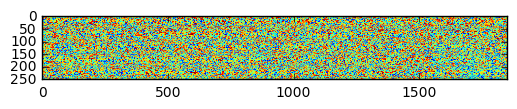

In [74]:
_=plt.imshow(pgram)
# _=plt.colorbar()

In [87]:
# Define frequency bands
bands=list()
bands.append((1,4)) # Delta
bands.append((4,8)) # Theta
bands.append((8,13)) # Alpha
bands.append((13,30)) # Beta
bands.append((30,50)) # Gamma
bands.append((70,100)) # High Gamma

wind_len=Sf
wind_step=int(np.round(Sf/10))
data1=ieeg[onset_chan_id,:]
data2=ieeg[contra_chan_id,:]
bp_plv, p_sec=cmpt_bp_plv(data1, data2, Sf, wind_len, wind_step, tpts_sec, bands)

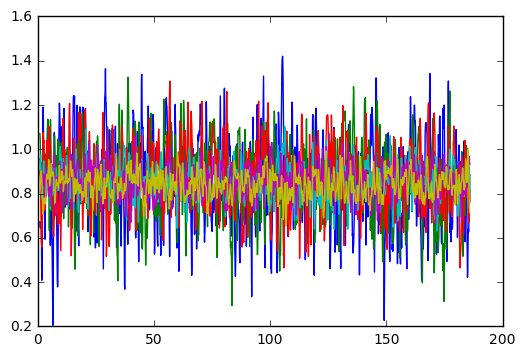

In [91]:
_=plt.plot(p_sec,bp_plv.T)

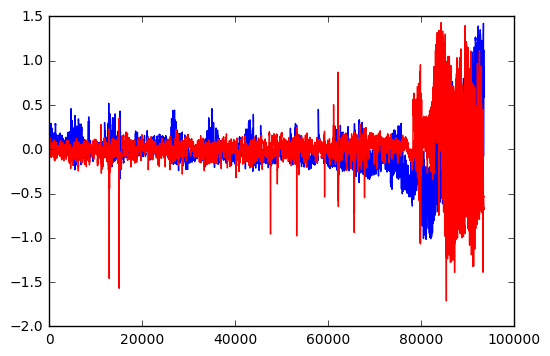

In [94]:
# _=plt.plot(data1[:500])
# _=plt.plot(data2[:500],'r')
_=plt.plot(data1)
_=plt.plot(data2,'r')

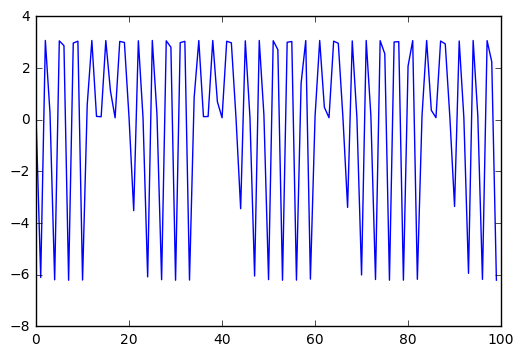

In [50]:
_=plt.plot(delta_phz[2,:100])

In [60]:
bro=np.abs(np.sum(np.exp(1j*delta_phz),axis=1))/n_wind
bro2=np.abs(np.mean(np.exp(1j*delta_phz),axis=1))
bro.shape

(251,)

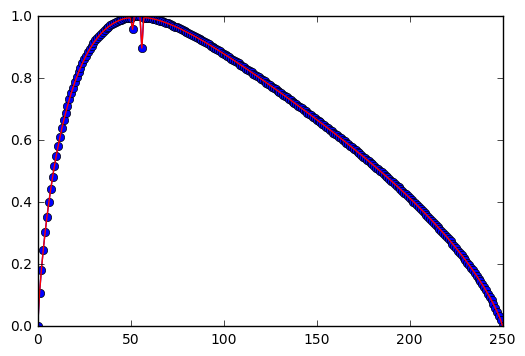

In [61]:
_=plt.plot(f,bro,'-o')
_=plt.plot(f,bro2,'r')

In [ ]:
# Import channel names
chan_labels=ief.import_chan_labels(sub)
ftr_list=list()
ftr_class_list=list()

# Loop over usable files
#for szr_ct, szr_name in enumerate(use_szrs[0:1]): # ?? REVERT
for szr_ct, szr_name in enumerate(use_szrs):
    # Load data
    in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'.mat')
    if not os.path.isfile(in_fname):
        # Must be a subclinical seizure
        in_fname=os.path.join(ieeg_root,sub,'EEG_MAT',szr_name+'_sc.mat')
    szr_name_full=in_fname.split('/')[-1]
    ieeg, Sf, tpts_sec=ief.import_ieeg(szr_name_full)

    # Adjust upper frequency band based on sampling rate
    bands[5]=(70,Sf*.4)
    print(bands)
    
    # Get time point and channel of szr onset
    onset_tpt, onset_chan=ief.clin_onset_tpt_and_chan(szr_name, onset_df)
    onset_chan_id = chan_labels.index(onset_chan)
    onset_sec=tpts_sec[onset_tpt]
    print(onset_sec)
    print(onset_tpt)
    print(onset_chan)
    
    # Run DFT 
    wind_len=Sf
    wind_step=Sf/10
    n_tapers=4
    db_pwr, sgram_sec=ief.bp_pwr(ieeg[onset_chan_id:onset_chan_id+1,:], Sf, wind_len, wind_step,
                                 n_tapers, tpts_sec, bands, taper='slepian')
    db_pwr=np.squeeze(db_pwr)
    # Trim norm
    dg.trimmed_normalize(db_pwr,.4)
    
    # Record class of each time point
    n_wind=len(sgram_sec)
    sgram_onset_id=dg.find_nearest(sgram_sec,onset_sec-4)
    sgram_term_id=dg.find_nearest(sgram_sec,onset_sec+9)
    peri_ictal=np.ones(n_wind,dtype=np.int8)
    peri_ictal[:sgram_onset_id]=0
    peri_ictal[sgram_term_id:]=-1 # ictal (and potentially post-ictal data) that should 
    # not be used for classification
    
    # output data
    ftrs_root=path_dict['ftrs_root']
    ftr_path=os.path.join(ftrs_root,'PWR',sub)
    if not os.path.isdir(ftr_path):
        os.mkdir(ftr_path)
    ftr_fname=os.path.join(ftr_path,szr_name+'_bppwr.npz')
    print('Saving features to file %s' % ftr_fname)
    np.savez(ftr_fname,peri_ictal=peri_ictal,time_wind_sec=sgram_sec,db_pwr=db_pwr)
#     ftr_fname=os.path.join(ftrs_root,'PWR',szr_name+'_bppwr.pkl')
#     pkl_handle=open(ftr_fname,'wb')
#     pickle.dump(ftr_fname,pkl_handle)
#     close(pkl_handle)

print('Done!')